## Multivariate linear regression with batch gradient descent

***

#### Process:

1. Import libraries (numpy, pandas, matplotlib)
2. Read data into DataFrame object
3. Implement cost function $J(\theta)$ for gradient descent
4. Run gradient descent to fit parameters $\theta$
5. Use cost function $h(\theta) = \sum_{i=0}^{n-1}\theta_{i}x_{i}$ to predict _y_ values

***

In [1]:
# Importing necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # for plotting 3-D graphs

In [2]:
# read text file into pandas DataFrame
df = pd.read_csv("ex1data2.txt", sep=",", header=None, names=["Area","Rooms","Price"])
df.head() # printing the data

,Area,Rooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


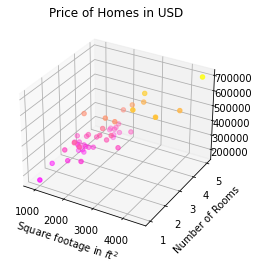

In [3]:
# plotting our data, 
# where our x-axis represents something and our y-axis represents something, 
# and our z-axis represents something

fig = plt.figure()
ax = plt.axes(projection="3d")

z_points = df["Price"]
x_points = df["Area"]
y_points = df["Rooms"]
ax.scatter3D(x_points, y_points, z_points, c=z_points, cmap='spring');
ax.set_ylabel('Number of Rooms')
ax.set_xlabel('Square footage in ${ft}^2$')
ax.set_title('Price of Homes in USD')

plt.show()

***
Now, it's time to **initialize necessary vectors**. 

We need:
 * _X_ - a matrix whose columns are different features of our data
 * _y_ - column vector whose entries are the final outputs of our training data
 * $\theta$ - row vector whose entries are the different parameters to our hypothesis function 

In [4]:
# Create feature vector X
X = np.ones(shape=(df.shape[0],1)) # x_0 is just ones
X = pd.DataFrame(X[:,0])
X[1] = df['Area'] # x_1 is the area
X[2] = df['Rooms'] # x_2 is the number of rooms

# Create y vector
y = df['Price'] 

# create a vector of theta parameters, 
# where the number of parameters is the number of features
theta = np.zeros(shape=(1, df.shape[1])) 
theta = pd.DataFrame(theta)

# bookkeeping dimensions
print(f"Dimensions of X are: {X.shape}")
print(f"Dimensions of y are: {y.shape}")
print(f"Dimensions of theta are: {theta.shape}")

Dimensions of X are: (47, 3)
Dimensions of y are: (47,)
Dimensions of theta are: (1, 3)


Now, what we should do is implement **feature scaling** to get all of our features within the same magnitude of size. It's best practice to aim for every feature $x_{i}$ to be in the range: $-1\leq x_{i}\leq 1$. 

The most common way to do this is by implementing **mean normalization**: $x_{i} := \frac{x_{i}-\mu}{\sigma}$, where $\mu$ is the average value of $x_{i}$ in the training set and $\sigma$ is either the range or the standard deviation of the $x_{i}$'s in the training set.

In [8]:
# variables for the scaled DataFrames
X_mean = X.mean() # stores the mean of each feature x_i in its own row
X_std = X.std() # stores the standard deviation of each feature x_i in its own row


# stores the scaled x_i values in a new dataframe
X_scaled = pd.DataFrame(np.zeros(shape=(X.shape)))

# we would get a divide by zero error if we tried to divide x_0 values by their standard deviation
X_scaled[0] = pd.DataFrame(np.ones(shape=(X.shape[0],1))) 

for i in range(1,X.shape[1]):
#     X_mean[i] = pd.DataFrame(np.ones(shape=(X.shape[0],1)) * X_mean[i])
    X_scaled[i] = (X[i] - X_mean[i]) / X_std[i]
    
X_scaled.head()

,0,1,2
0,1.0,0.130010,-0.223675
1,1.0,-0.504190,-0.223675
2,1.0,0.502476,-0.223675
3,1.0,-0.735723,-1.537767
4,1.0,1.257476,1.090417


***
It's almost time to run gradient descent! 

We just need to define our **cost function** $J(\theta)$ as follows:
$$ J(\theta) = \frac{1}{2m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})^{2} $$

where $m$ is the number of training examples, $h(\theta) = \sum_{i=0}^{n-1}\theta_{i}x_{i}$ is our hypothesis function ($n$ represents the number of features), and the superscript $(i)$ represents the value corresponding to the $i^{\textrm{th}}$ training example.


$J(\theta)$ should return a scalar value.

In [9]:
J = 0 # initializes our cost function J


# computes the summation part of J
for i in range(df.shape[0]):
    J += (((theta[0] * X_scaled.iat[i,0]) + (theta[1] * X_scaled.iat[i,1]) + (theta[2] * X_scaled.iat[i,2]) - y[i]) ** 2)

J = J / (2 * df.shape[0])

Now that we have our cost function all set up, the only thing we need to do now is **run gradient descent!**

***

Our gradient descent algorithm repeats the following assignment until convergence:
$$\theta_{j} := \theta_{j} - \frac{\partial}{\partial \theta_{j}}J(\theta)$$    (for $0\leq j \leq n$)

and after evaluating the partial derivatives, we get that our algorithm repeats the following *simultaneous* assignments until convergence:

$$\theta_{j} := \theta_{j} - \alpha\frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})\cdot x^{(i)}$$ (for $0\leq j \leq n$)

* We call this algorithm **batch gradient descent**, as it goes through *every* training example each iteration. 
* $\alpha$ is what we call the **learning rate**, and depending on how big or small it is, our algorithm will either converge faster, slower, or maybe even not at all!
* Notice that every $\theta_{j}$ is updated *simultaneously*; if they were instead updated procedurally, then for each iteration, $\theta_{j}$ and $\theta_{j+1}$, (where $0\leq j<j+1\leq n$) would be using different values for $h_{\theta}(x^{(i)})$, which is not what we want. 

(If we were to update each individual $\theta_{j}$ procedurally, our psuedo-gradient function would actually still work, but it wouldn't be considered gradient descent.)


In order to update our $\theta_{j}$ values simultaneously, we will employ the use of a *temporary variable* `temp_theta` to act as a placeholder for $\theta$ each iteration of gradient descent.

In [10]:
#### Implementing gradient descent ####
%matplotlib inline

# number of iterations
iter = 1000

# learning rate
alpha = 0.01

for i in range(iter):
    temp_theta = theta
    
    ### updating theta_1 ###
    for j in range(df.shape[1]):
        sum_j = 0 # the value of the summation for theta_j
        
        for k in range(df.shape[0]): # computes the sum through each training example
            sum_j += ((temp_theta[0] * X_scaled.iat[k,0]) + (temp_theta[1] * X_scaled.iat[k,1]) + (temp_theta[2] * X_scaled.iat[k,2]) - y[k]) * X_scaled.iloc[k]
        theta[j] = temp_theta[j] - ((alpha / df.shape[0]) * sum_j) 
    
#     print(f"iter={i}: {float(theta[0])},{float(theta[1])},{float(theta[2])}")

***
Now that we've fit our parameter vector $\theta$, let's use it in our hypothesis function $h_{\theta}$ to make predictions of cost based on house size and number of bedrooms!

*(Remember that our values that we are working with are scaled, so we will have to scale our inputs before plugging them into our hypothesis function.)*

For example, we will predict the price of a 3 bedroom house with an area of 2000 $\text{ft}^2$ using our hypothesis function $h_{\theta}$:

In [11]:
inputs = [1,2000,3]
area = inputs[1]
rooms = inputs[2]

predicted_price = theta.iat[0,0] * inputs[0]
for i in range(1,len(inputs)):
    inputs[i] = (inputs[i] - X_mean.iat[i]) / X_std[i]
    predicted_price += theta[i] * inputs[i]
print(f"Predicted price for {rooms} room, {area} sq ft house is ${int(predicted_price)}")

Predicted price for 3 room, 2000 sq ft house is $264732


Finally, replotting our original training data, but now with our predicted value plotted in orange, we get:

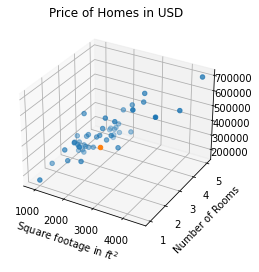

In [12]:
fig = plt.figure()
ax = plt.axes(projection="3d")

# scatter plot
z_points = df["Price"]
x_points = df["Area"]
y_points = df["Rooms"]
ax.scatter3D(x_points, y_points, z_points, c=None, cmap='spring');
ax.scatter3D(area, rooms, predicted_price)
ax.set_ylabel('Number of Rooms')
ax.set_xlabel('Square footage in ${ft}^2$')
ax.set_title('Price of Homes in USD')

plt.show()

***
## Voila!
    
We've successfully implemented multivariate linear regression! We can scale our model to input more features if we really want, though it would be impossible to graph past the (small number of) 2 features that we have here. 

Moreover, if we have a sufficiently small number of features, say, $n < 10000$, we can use something called **normal equations** in leiu of gradient descent to calculate $\theta$. For reference, the normal equation implementation involves the following computation: $\theta = (X^{T}X)^{-1}X^{T}\vec{y}$. Try to implement it and see what happens!